In [15]:
from langgraph.graph import StateGraph, START, END 
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from typing import TypedDict, Annotated
import os
from dotenv import load_dotenv 
from pydantic import BaseModel, Field
import operator


In [16]:
load_dotenv(dotenv_path= r'C:\Users\shekh\OneDrive\Desktop\LangGraph_tut\myenv\.env')

True

In [17]:
HF_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")


In [18]:
llm = HuggingFaceEndpoint(
    repo_id= 'meta-llama/Llama-3.1-8B-Instruct',
    task='text-generation',
    huggingfacehub_api_token= HF_TOKEN
)

model = ChatHuggingFace(llm = llm)      

In [19]:
class EvaluationSchema(BaseModel):
    score: int = Field(..., description="Score out of 10", ge=0, le=10)
    feedback: str = Field(..., description="Constructive feedback on the essay")

structured_model = model.with_structured_output(EvaluationSchema, method="json_schema")


In [20]:
with open('AI_Impact_on_Young_Generation.txt', 'r') as file:
    essay = file.read()

In [21]:
class UPSC_States(TypedDict):
    essay: str
    language_feedback: str
    clarity_feedback: str
    analysis_feedback: str
    indidual_score: Annotated[list[int], operator.add]
    avg_score: float
    overall_feedback: str

In [30]:
def evaluate_language(state: UPSC_States) -> UPSC_States:
    prompt = f"""Please evaluate the language quality of following essay and provide a score out of 10 along with constructive feedback:\n\n{state['essay']}"""
    result = structured_model.invoke(prompt)
    feedback = result["feedback"]   # dict access
    score = result["score"]
    return {
        'language_feedback': feedback,
        'individual_score': [score]  # also fixed spelling!
    }


In [31]:
def evaluate_analysis(state: UPSC_States) -> UPSC_States:
    prompt = f"""Please evaluate the depth of analysis of following essay and provide a score out of 10 along with constructive feedback:\n\n{state['essay']}"""
    result = structured_model.invoke(prompt)
    feedback = result["feedback"]   # dict access
    score = result["score"]
    return {'analysis_feedback': feedback, 'individual_score': [score]}

In [37]:
def evaluate_clarity(state: UPSC_States) -> UPSC_States:
    prompt = f"""Please evaluate the clarity of thought of following essay and provide a score out of 10 along with constructive feedback:\n\n{state['essay']}"""
    result = structured_model.invoke(prompt)
    feedback = result["feedback"]   # dict access
    score = result["score"]
    return {'clarity_feedback': feedback, 'indidual_score': [score]}

In [38]:
def final_evaluation(state: UPSC_States) -> UPSC_States:
    prompt = f"""based on the following feedbacks, provide an overall evaluation of the essay along with an average score out of 10:\n\nLanguage Feedback: {state['language_feedback']}\n\nAnalysis Feedback: {state['analysis_feedback']}\n\nClarity Feedback: {state['clarity_feedback']}"""
    overall_feedback = model.invoke(prompt)
    
    # Calculate average score
    avg_score = sum(state['indidual_score']) / len(state['indidual_score'])
    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [39]:
graph = StateGraph(UPSC_States)
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_clarity', evaluate_clarity)
graph.add_node('final_evaluation', final_evaluation)

graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_clarity')
graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_clarity', 'final_evaluation')
graph.add_edge('final_evaluation', END)

# compile the graph
workflow = graph.compile()



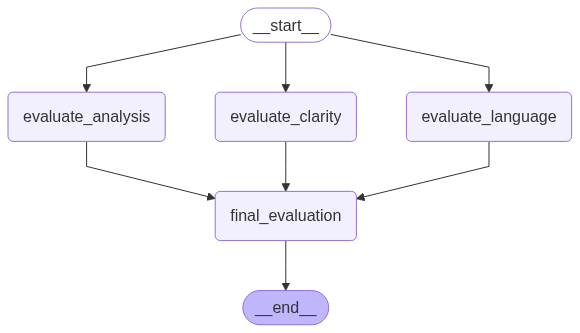

In [40]:
workflow

In [41]:
initial_state = {'essay': essay}
result = workflow.invoke(initial_state)

In [42]:
result

{'essay': 'Impacts of Artificial Intelligence on Young Generation\n\nArtificial Intelligence (AI) has become one of the most influential\ntechnologies of the 21st century, reshaping industries, societies, and\nindividual lifestyles. Among the groups most affected by AI is the young\ngeneration, who are both the primary users and future innovators of this\ntechnology. While AI offers immense benefits, it also presents notable\nchallenges that shape the lives, skills, and opportunities of young\npeople.\n\nOne of the most positive impacts of AI on the young generation is the\nenhancement of education. Intelligent tutoring systems, adaptive\nlearning platforms, and AI-driven content personalization make education\nmore engaging and tailored to individual learning styles. Students can\naccess resources beyond traditional classrooms, breaking geographical\nbarriers and ensuring inclusivity. This fosters a more self-paced and\neffective learning environment.\n\nAI has also revolutionized car

In [45]:
result['language_feedback']

'Overall, the essay is well-structured and covers a wide range of impacts of AI on the young generation. However, there are some areas for improvement to reach a perfect score.'